In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [3]:
!ls ./out && ls ./data

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
bus_id_encoder     = pickle.load(open("./out/bus_id_encoder.pickle"    , "rb"))
route_id_encoder   = pickle.load(open("./out/route_id_encoder.pickle"  , "rb"))
busstop_id_encoder = pickle.load(open("./out/busstop_id_encoder.pickle", "rb"))

In [5]:
dummy_buses = [325819008, 451509115]
print("bus ids", dummy_buses)
print("bus categorical ids", bus_id_encoder.transform(dummy_buses))

dummy_routes = [11100010, 11100012]
print("route ids", dummy_routes)
print("route categorical ids", route_id_encoder.transform(dummy_routes))

dummy_busstops = [388, 112]
print("busstop ids", dummy_busstops)
print("busstop categorical ids", busstop_id_encoder.transform(dummy_busstops))


bus ids [325819008, 451509115]
bus categorical ids [578 664]
route ids [11100010, 11100012]
route categorical ids [3 4]
busstop ids [388, 112]
busstop categorical ids [387 111]


In [6]:
dataset_df  = pd.read_csv("./out/cleaned_train.csv")

In [7]:
dataset_input = dataset_df[['DAY_OF_WEEK', 'TIME', 'BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID']]
dataset_label = dataset_df[['TIMESTAMP_DIFF']]

In [8]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                        np.arange(d_model)[np.newaxis, :],
                        d_model)
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype=tf.float32)

In [9]:
time_dim      = 64
total_seconds = 18*3600 # 18hours
pos_encoding  = positional_encoding(total_seconds, time_dim)
print(pos_encoding.shape)

(1, 64800, 64)


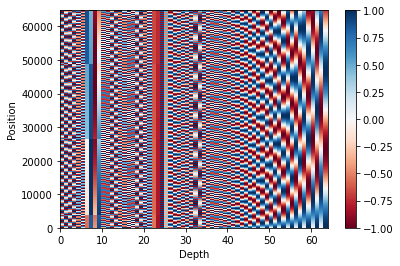

In [10]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, time_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [11]:
class BusNet(tf.keras.Model):
  def __init__(self, **kwargs):
    super(BusNet, self).__init__(**kwargs)
    
    self.week          = [0, 1, 2, 3, 4, 5, 6]
    self.time_dim      = 64
    self.time_count    = 18*3600

    self.bus_dim       = 32
    self.bus_count     = 1077

    self.route_dim     = 16
    self.route_count   = 353

    self.busstop_dim   = 32
    self.busstop_count = 1357
    
    self.dropout_rate  = 0.2

    self.day_of_week_embedding = tf.keras.layers.Embedding(len(self.week), len(self.week), embeddings_initializer='uniform', name='day_of_week_embedding')
    self.time_encoding         = positional_encoding(self.time_count, self.time_dim)
    self.time_embedding        = tf.keras.layers.Embedding(self.time_count, self.time_dim, weights=[self.time_encoding[0]]       , name='time_embedding')
    self.bus_embedding         = tf.keras.layers.Embedding(self.bus_count    , self.bus_dim    , embeddings_initializer='uniform', name='bus_embedding'    )
    self.route_embedding       = tf.keras.layers.Embedding(self.route_count  , self.route_dim  , embeddings_initializer='uniform', name='route_embedding'  )
    self.busstop_embedding     = tf.keras.layers.Embedding(self.busstop_count, self.busstop_dim, embeddings_initializer='uniform', name='busstop_embedding')

    self.layer_1      = tf.keras.layers.Dense(100, activation='relu')
    self.dropout_1    = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_2      = tf.keras.layers.Dense(64 , activation='relu')
    self.dropout_2    = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_3      = tf.keras.layers.Dense(32 , activation='relu')
    self.dropout_3    = tf.keras.layers.Dropout(self.dropout_rate)
    self.output_layer = tf.keras.layers.Dense(1)

  def call(self, inputs, training=True):
    days_of_week   = inputs[:, 0]
    time_positions = inputs[:, 1]
    bus_ids        = inputs[:, 2]
    route_ids      = inputs[:, 3]
    busstop_ids    = inputs[:, 4]

    day_vectors     = self.day_of_week_embedding(days_of_week)
    time_vectors    = self.time_embedding(time_positions)
    bus_vectors     = self.bus_embedding(bus_ids)
    route_vectors   = self.route_embedding(route_ids)
    busstop_vectors = self.busstop_embedding(busstop_ids)
    
    concatted_input = tf.concat([
      day_vectors  ,
      time_vectors , 
      bus_vectors  , 
      route_vectors, 
      busstop_vectors
      ], 1)
    
    x = self.layer_1(concatted_input)
    x = self.dropout_1(x, training=training)
    x = self.layer_2(x)
    x = self.dropout_2(x, training=training)
    x = self.layer_3(x)
    x = self.dropout_3(x, training=training)
    
    return self.output_layer(x)

In [12]:
model = BusNet(dynamic=True)

In [13]:
optimizer = tf.keras.optimizers.Adam()
ckpt      = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager   = tf.train.CheckpointManager(ckpt, './checkpoints_time_embedding', max_to_keep=3)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))
else:
  print("Initializing from scratch.")

Restored from ./checkpoints_time_embedding\ckpt-261


In [14]:
window_index = 50000
y = model(dataset_input[window_index-3:window_index+3].values, training=False)
print("predicted:")
print(y.numpy())
print("true values:")
print(dataset_label[window_index-3:window_index+3].values)

m = tf.keras.metrics.MeanAbsoluteError()
_ = m.update_state(y, dataset_label[window_index-3:window_index+3].values) 
print("mean absolute error:", m.result().numpy())

predicted:
[[103.704636]
 [ 81.227554]
 [110.66873 ]
 [155.86652 ]
 [118.72453 ]
 [345.742   ]]
true values:
[[ 83.]
 [ 59.]
 [ 79.]
 [152.]
 [ 93.]
 [342.]]
mean absolute error: 17.988997


In [15]:
test_df = pd.read_csv("./data/test.csv")

In [16]:
test_df

,index,BUSROUTE_ID,BUS_ID,BUSSTOP_ID,BUSSTOP_SEQ,RECORD_DATE,TIMESTAMP
0,3220254,11100010,2054,11,3,2020-01-22 09:23:36,1.579685e+09
1,3220255,11100010,2054,9,4,NaN,NaN
2,3220256,11100010,2054,6,5,2020-01-22 09:27:26,1.579685e+09
3,3220257,11100010,2054,4,6,NaN,NaN
4,3220258,11100010,2054,147,7,NaN,NaN
...,...,...,...,...,...,...,...
1557459,4777713,12100232,740518021,657,9,2020-01-24 16:39:27,1.579884e+09
1557460,4777714,12100232,740518021,219,2,2020-01-24 17:28:00,1.579887e+09
1557461,4777715,12100232,740518021,221,3,NaN,NaN
1557462,4777716,12100232,740518021,242,4,NaN,NaN


In [17]:
import random

cleaned_buses = dataset_df['BUS_ID'].unique()

In [18]:
def timestamp_to_dayofweek(time):
  return (time//3600//24 + 3) % 7

def timestamp_to_timeposition(time, starting_time = 21600): 
  if time < starting_time:
    return 0
  return (time - starting_time) % 86400

In [19]:
# ['DAY_OF_WEEK', 'TIME', 'BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID']
for idx, row in test_df.iterrows():
  if (pd.isna(row['TIMESTAMP'])):
    timestamp = test_df.iloc[idx-1]['TIMESTAMP']
    prev_row  = test_df.iloc[idx-1]
    if (not pd.isna(timestamp)):
      day_of_week   = int(timestamp_to_dayofweek(timestamp))
      time_position = int(timestamp_to_timeposition(timestamp))
      
      bus_id = int(prev_row['BUS_ID'])
      try:
        bus_position = bus_id_encoder.transform([bus_id])[0]
      except:
        bus_position = random.choice(cleaned_buses)
      
      route_id       = int(prev_row['BUSROUTE_ID'])
      route_position = route_id_encoder.transform([route_id])[0]
      
      busstop_id       = int(prev_row['BUSSTOP_ID'])
      busstop_position = busstop_id_encoder.transform([busstop_id])[0]

      model_input = np.array([[day_of_week, time_position, bus_position, route_position, busstop_position]])
      prediction  = int(model(model_input, training=False))
      
      test_df.at[idx, 'TIMESTAMP'] = timestamp + prediction

  if idx%5000==0:
    print("completed at", idx)

completed at 0
completed at 5000
completed at 10000
completed at 15000
completed at 20000
completed at 25000
completed at 30000
completed at 35000
completed at 40000
completed at 45000
completed at 50000
completed at 55000
completed at 60000
completed at 65000
completed at 70000
completed at 75000
completed at 80000
completed at 85000
completed at 90000
completed at 95000
completed at 100000
completed at 105000
completed at 110000
completed at 115000
completed at 120000
completed at 125000
completed at 130000
completed at 135000
completed at 140000
completed at 145000
completed at 150000
completed at 155000
completed at 160000
completed at 165000
completed at 170000
completed at 175000
completed at 180000
completed at 185000
completed at 190000
completed at 195000
completed at 200000
completed at 205000
completed at 210000
completed at 215000
completed at 220000
completed at 225000
completed at 230000
completed at 235000
completed at 240000
completed at 245000
completed at 250000
compl

In [20]:
test_df[['index', 'TIMESTAMP']].to_csv("./out/output1.csv", index=False)